# True val Calculations for Fig 8 (Chris)


## Panel A and C:
Normal was sampled from rnorm in R with mean=0 var=2
Cancer was sampled from rnorm in R with mean=0 var=1 

## Panel B and D
Normal was sampled from rnorm in R with mean=0 var=2
Cancer  90% sampled mean=0 var=1 and 10% sampled mean=5 var=1

(A) for each variable, compute the true/Bayes:
1. MI
2. correlation
3. AUC
4. pAUC
5. S@98
6. Accuracy
7. F1

(B) plot the true distributions, and sample, eg 512 samples (assuming normals are 50%) from them and overlay histograms

# Notes from meeting Feb 8
* Keep the Controle to N(0,1)
* Aim for S@98 for Var C at 0.2
* Remove Var B?
* Show Null case where Control = Cancer

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd

sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)


def truncate(n, dicimals=2):
    return round(n, dicimals)


# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return ">"
    elif A < B:
        return "<"
    else:
        return "="

          Variable B
Accuracy        0.59
F1              0.63
MI              0.21
AUC             0.64
pAUC            0.55
S@98            0.11


Text(0.5, 1.0, 'ROC Curve')

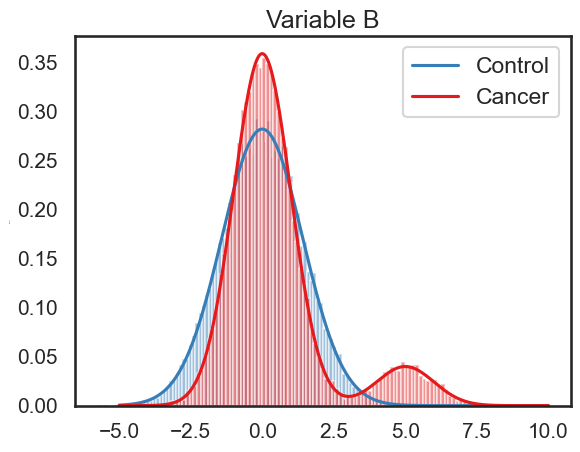

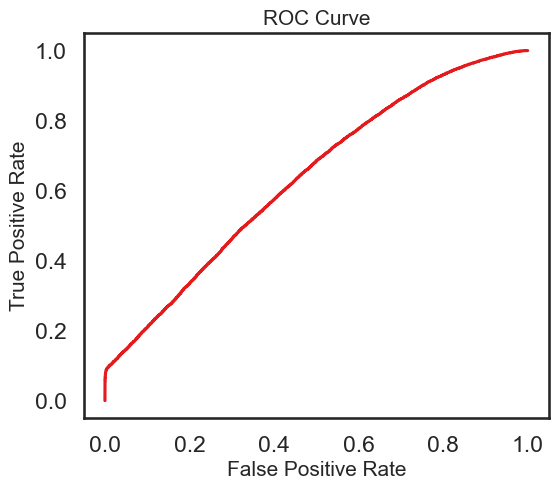

In [151]:
import warnings

warnings.filterwarnings("ignore")

# Panel B & C Normal : N(0,2) vs Cancer  N(0,1)
N = 50000
prior_0, prior_1 = 0.5, 0.5
p_class0, p_class1_0, p_class1_1 = prior_0, prior_1 * 0.9, prior_1 * 0.1
p_class1 = p_class1_0 + p_class1_1
n0 = int(N * p_class0)
n1 = N - n0
n1_0 = int(n1 * 0.9)
n1_1 = n1 - n1_0
p = 1
p0, p1 = 2, 1
mu_class0 = np.array([0] * p)
mu_class1_0 = np.array([0] * p)
mu_class1_1 = np.array([5] * p)
sig_class0 = np.identity(p) * p0
sig_class1_0 = np.identity(p) * p1
sig_class1_1 = np.identity(p) * p1

density = True

# Create the probability density functions (PDFs) for the two Gaussian distributions
pdf_class0 = multivariate_normal(mu_class0, sig_class0)
pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
pdf_class1 = np.zeros_like(pdf_class0)


x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
x_2_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
x_2_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
x_2 = np.vstack((x_2_0, x_2_1))

x = np.vstack((x_1, x_2))
y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

p_x_given_class0 = pdf_class0.pdf(x)
p_x_given_class1_0 = pdf_class1_0.pdf(x)
p_x_given_class1_1 = pdf_class1_1.pdf(x)

p_x_given_class1 = 0.9 * p_x_given_class1_0 + 0.1 * p_x_given_class1_1


p_x = (
    p_x_given_class0 * p_class0
    + p_x_given_class1_0 * p_class1_0
    + p_x_given_class1_1 * p_class1_1
)
pos_class0 = p_x_given_class0 * p_class0 / p_x
# pos_class1_0 = p_x_given_class1_0*p_class1_0/p_x
# pos_class1_1 = p_x_given_class1_1*p_class1_1/p_x
pos_class1 = p_x_given_class1 * p_class1 / p_x

posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
# print(posterior.shape)
# posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
prior_y = np.array([p_class0, p_class1_0, p_class1_1])
entropy_y = entropy(prior_y, base=np.exp(1))
# print('entropy'+str(stats_conen))

# correlation = np.corrcoef(x_1.T, x_2.T)
MI = entropy_y - stats_conen
auc = roc_auc_score(y, posterior[:, 1])
pauc = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
fpr, tpr, thresholds = metrics.roc_curve(
    y, posterior[:, 1], pos_label=1, drop_intermediate=False
)
tpr_s = np.max(tpr[fpr <= 0.02])
y_pred = np.argmax(posterior, axis=1)
accuracy = metrics.accuracy_score(y, y_pred)
tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = metrics.f1_score(y, y_pred)
report = metrics.classification_report(y, y_pred)

statistics_B = {
    # 'Correlation': truncate(correlation[0,1], 4),
    "Accuracy": round(accuracy, 2),
    "F1": round(f1, 2),
    "MI": round(MI, 2),
    "AUC": round(auc, 2),
    "pAUC": round(pauc, 2),
    "S@98": round(tpr_s, 2),
    # 'Sensitivity': truncate(sensitivity),
    # 'Specificity': truncate(specificity),
    # 'TN': tn,
    # 'FP': fp,
    # 'FN': fn,
    # 'TP': tp
}
statistics_B_list = list(statistics_B.values())
# print the statistics as a dataframe
print(
    pd.DataFrame(statistics_B_list, index=statistics_B.keys(), columns=["Variable B"])
)

# # plot the true pdfs
# x = np.linspace(-5, 10, 1000)
# plt.plot(x, pdf_class0.pdf(x), label='Control', color='b')
# plt.plot(x, 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x), label='Cancer', color='r')
# # plt.plot(x, pdf_class1_1.pdf(x), label='N(5,1)', color='b')
# # sample from the true pdfs to plot the histograms
# plt.hist(x_1, bins=100, density=True, alpha=0.5, color='b')
# # combine the two cancer classes
# x_2 = np.vstack((x_2_0,x_2_1))
# plt.hist(x_2, bins=100, density=True, alpha=0.5, color='r')

# plt.legend()
# plt.title('Variable B')

# plot the true pdfs using seaborn
x = np.linspace(-5, 10, 1000)
# create a df to plot the true pdfs using seaborn
df = pd.DataFrame(
    {
        "x": x,
        "pdf_class0": pdf_class0.pdf(x),
        "pdf_class1": 0.9 * pdf_class1_0.pdf(x) + 0.1 * pdf_class1_1.pdf(x),
    }
)
scaler = 8
# sample from the true pdfs to plot the histograms
plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
# plt.plot(df['x'], df['pdf_class0']*n0/scaler, color=PALETTE[1], linewidth=2)
# plt.plot(df['x'], df['pdf_class1']*n1/scaler, color=PALETTE[0], linewidth=2)
# plot the true pdf
sns.lineplot(df, x="x", y="pdf_class0", label="Control", color=PALETTE[1])
sns.lineplot(df, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0])
# plt.legend(['Control', 'Cancer'])

# plt.hist(x_1, bins=100,  alpha=0.5, color=PALETTE[1])
# plt.hist(x_2, bins=100,  alpha=0.5, color=PALETTE[0])
# set the labels and title
plt.xlabel("")
plt.ylabel("Density", size=0.5)
# set the ticks size
plt.xticks(size=15)
plt.yticks(size=15)
# set the legent size
sns.set_context("talk", font_scale=1.0)

plt.title("Variable B")

# convert the fpr, tpr, thresholds in a dataframe
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
# plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[0])
plt.xlabel("False Positive Rate", size=15.0)
plt.ylabel("True Positive Rate", size=15.0)
plt.title("ROC Curve", size=15.0)

In [171]:
# Define a function to calculate the statistics for Variable B
def calculate_statistics_B(
    n0,
    n1_0,
    n1_1,
    p,
    mu_class0,
    mu_class1_0,
    mu_class1_1,
    sig_class0,
    sig_class1_0,
    sig_class1_1,
    p_class0,
    p_class1_0,
    p_class1_1,
    plot=False,
    density=True,
    scaler=8,
    label="Variable C",
    split=(0.75, 0.25),
):
    N = n0 + n1_0 + n1_1
    n1 = N - n0
    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
    pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
    # pdf_class1 = pdf_class1_0 + pdf_class1_1

    x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
    x_2_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
    x_2_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
    x_2 = np.vstack((x_2_0, x_2_1))

    x = np.vstack((x_1, x_2_0, x_2_1))
    y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

    p_x_given_class0 = pdf_class0.pdf(x)
    p_x_given_class1_0 = pdf_class1_0.pdf(x)
    p_x_given_class1_1 = pdf_class1_1.pdf(x)
    # mix the two cancer classes
    p_x_given_class1 = split[0] * p_x_given_class1_0 + split[1] * p_x_given_class1_1

    p_x = (
        p_x_given_class0 * p_class0
        + p_x_given_class1_0 * p_class1_0
        + p_x_given_class1_1 * p_class1_1
    )
    pos_class0 = p_x_given_class0 * p_class0 / p_x
    pos_class1 = p_x_given_class1 * (1 - p_class0) / p_x

    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0, p_class1_0, p_class1_1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # correlation = np.corrcoef(x_1.T, x_2.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:, 1])
    pauc_90 = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
    pauc_98 = roc_auc_score(y, posterior[:, 1], max_fpr=0.02)
    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = metrics.f1_score(y, y_pred)
    report = metrics.classification_report(y, y_pred)

    statistics_B = {
        # 'Correlation': truncate(correlation[0,1], 4),
        "Accuracy": accuracy,
        "F1": f1,
        "MI": MI,
        "AUC": auc,
        "pAUC_90": pauc_90,
        "pAUC_98": pauc_98,
        "S@98": tpr_s,
        # 'Sensitivity': truncate(sensitivity),
        # 'Specificity': truncate(specificity),
        # 'TN': tn,
        # 'FP': fp,
        # 'FN': fn,
        # 'TP': tp
    }
    if plot:
        # plot the true pdfs using seaborn
        fig, ax = plt.subplots(figsize=(6, 5))
        x = np.linspace(-5, 10, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame(
            {
                "x": x,
                "pdf_class0": pdf_class0.pdf(x),
                "pdf_class1": split[0] * pdf_class1_0.pdf(x) + split[1] * pdf_class1_1.pdf(x),
            }
        )
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
        # find the quantiles of the posterior
        quantile = np.quantile(x_1, [accuracy])
        # plot the quantile
        # plt.axvline(x=quantile, color='g', linestyle='--', label='Threshold')
        # plot the true pdfs
        if density:
            sns.lineplot(df, x="x", y="pdf_class0", label="Control", color=PALETTE[1])
            sns.lineplot(df, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0])
        else:
            plt.plot(
                df["x"], df["pdf_class0"] * n0 / scaler, color=PALETTE[1], linewidth=2
            )
            plt.plot(
                df["x"], df["pdf_class1"] * n1 / scaler, color=PALETTE[0], linewidth=2
            )
            plt.legend(["Control", "Cancer"])

        # set the labels and title
        plt.xlabel("")
        plt.ylabel("Density", size=0.5)
        # set the ticks size
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.title(
            f"{label}: N({mu_class0[0]},{p0}) vs {split[0]}*N({mu_class1_0[0]},{p1}) + {split[1]}*N({mu_class1_1[0]},{p1})"
        )

        # plot the ROC curve
        # convert the fpr, tpr, thresholds in a dataframe
        df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
        # plot the ROC curve
        plt.figure(figsize=(6, 5))
        plt.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[0])
        plt.xlabel("False Positive Rate", size=15.0)
        plt.ylabel("True Positive Rate", size=15.0)
        plt.title(f"ROC Curve: {label}", size=15.0)

        return statistics_B, report, fig, posterior
    return statistics_B, report, posterior

,Variable B
Accuracy,0.621760
F1,0.579004
MI,0.378231
AUC,0.690768
pAUC_90,0.622395
pAUC_98,0.611779
S@98,0.251600


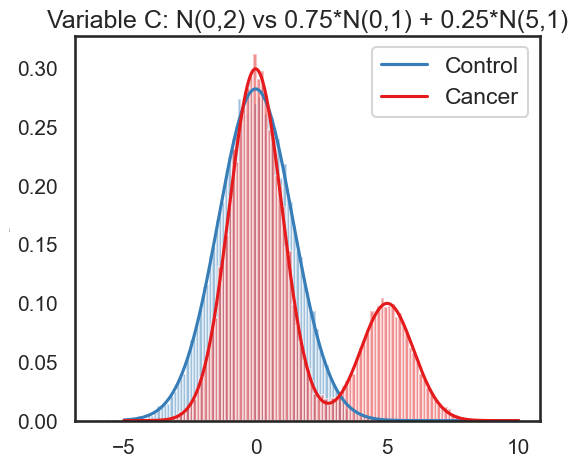

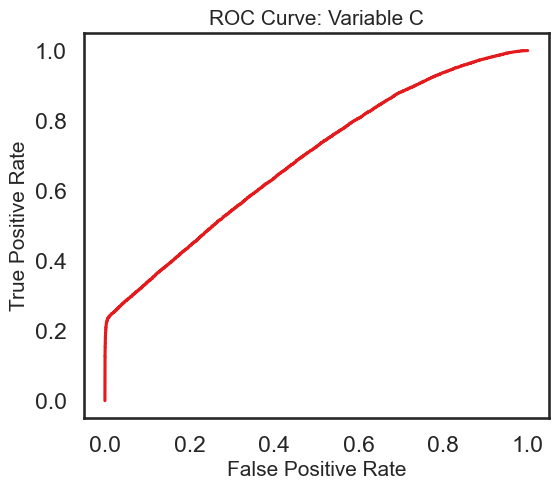

In [172]:
from re import split


density = True
N = 50000
split = (0.75, 0.25)
prior_0, prior_1 = 0.5, 0.5
p_class0, p_class1_0, p_class1_1 = prior_0, prior_1 * split[0], prior_1 * split[1]
n0 = int(N * p_class0)
n1 = N - n0
n1_0 = int(n1 * split[0])
n1_1 = n1 - n1_0
p = 1
p0, p1 = 2, 1
mu_class0 = np.array([0] * p)
mu_class1_0 = np.array([0] * p)
mu_class1_1 = np.array([5] * p)
sig_class0 = np.identity(p) * p0
sig_class1_0 = np.identity(p) * p1
sig_class1_1 = np.identity(p) * p1

statistics_B, report, fig_B, posterior = calculate_statistics_B(
    n0,
    n1_0,
    n1_1,
    p,
    mu_class0,
    mu_class1_0,
    mu_class1_1,
    sig_class0,
    sig_class1_0,
    sig_class1_1,
    p_class0,
    p_class1_0,
    p_class1_1,
    plot=True,
    density=density,
    scaler=8,
    split=split,
)
statistics_B_list = np.array(list(statistics_B.values()))
# print the statistics as a dataframe
pd.DataFrame(statistics_B_list, index=statistics_B.keys(), columns=["Variable B"])

          Variable A
Accuracy    0.582890
F1          0.645854
MI          0.027760
AUC         0.609184
pAUC        0.511691
S@98        0.028880


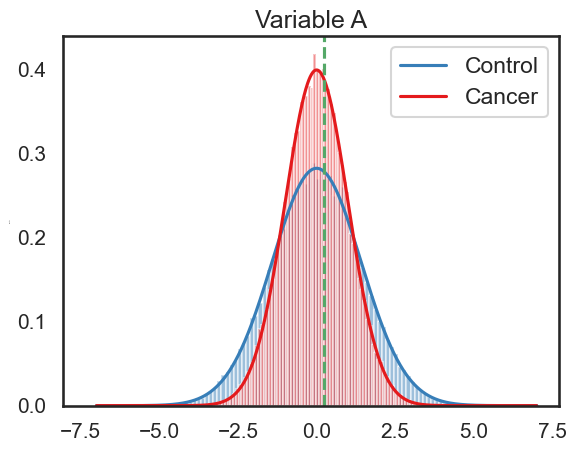

In [167]:
# Variable A Normal : N(-1,1) vs Cancer  N(1,1)
# supress warnings
import warnings

warnings.filterwarnings("ignore")


p = 1  # number of features
p0, p1 = 2, 1  # variances of the two classes
mu_class0 = np.array([0] * p)
mu_class1 = np.array([0] * p)
sig_class0 = np.identity(p) * p0
sig_class1 = np.identity(p) * p1

N = 100000
p_class0, p_class1 = 0.5, 0.5
n0 = int(N * p_class0)
n1 = N - n0
p = 1
p0, p1 = 2, 1
mu_class0 = np.array([0] * p)
mu_class1 = np.array([0] * p)
sig_class0 = np.identity(p) * p0
sig_class1 = np.identity(p) * p1


density = True
scaler = 12

# Create the probability density functions (PDFs) for the two Gaussian distributions
pdf_class0 = multivariate_normal(mu_class0, sig_class0)
pdf_class1 = multivariate_normal(mu_class1, sig_class1)


x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

x = np.vstack((x_0, x_1))
y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

p_x_given_class0 = pdf_class0.pdf(x)
p_x_given_class1 = pdf_class1.pdf(x)


p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1
pos_class0 = p_x_given_class0 * p_class0 / p_x
pos_class1 = p_x_given_class1 * p_class1 / p_x


posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
# print(posterior.shape)
# display(posterior[:5])
# posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
prior_y = np.array([p_class0, p_class1])
entropy_y = entropy(prior_y, base=np.exp(1))

# correlation = np.corrcoef(x_1.T, x_2.T)
MI = entropy_y - stats_conen
auc = roc_auc_score(y, posterior[:, 1])
pauc = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
fpr, tpr, thresholds = metrics.roc_curve(
    y, posterior[:, 1], pos_label=1, drop_intermediate=False
)
# find the threshold for accuracy at auc
threshhold = thresholds[np.argmax(tpr - fpr)]


tpr_s = np.max(tpr[fpr <= 0.02])
y_pred = np.argmax(posterior, axis=1)
accuracy = metrics.accuracy_score(y, y_pred)
tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
# accuracy = (tp+tn)/(tp+tn+fp+fn)
accuracy_ = (tp + tn) / (tp + tn + fp + fn)
# print(accuracy, accuracy_)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = metrics.f1_score(y, y_pred)
report = metrics.classification_report(y, y_pred)

statistics_A = {
    # 'Correlation': truncate(correlation[0,1], 4),
    "Accuracy": accuracy,
    "F1": f1,
    "MI": MI,
    "AUC": auc,
    "pAUC": pauc,
    "S@98": tpr_s,
    # 'threshold': thresholds,
    # 'Sensitivity': truncate(sensitivity),
    # 'Specificity': truncate(specificity),
    # 'TN': tn,
    # 'FP': fp,
    # 'FN': fn,
    # 'TP': tp
}
# find the threshold for accuracy at auc

statistics_A_list = list(statistics_A.values())
# print the statistics as a dataframe
print(
    pd.DataFrame(statistics_A_list, index=statistics_A.keys(), columns=["Variable A"])
)
# plot the true pdfs using seaborn
xs = np.linspace(-7, 7, 1000)
# create a df to plot the true pdfs using seaborn
df = pd.DataFrame(
    {"x": xs, "pdf_class0": pdf_class0.pdf(xs), "pdf_class1": pdf_class1.pdf(xs)}
)
# plot the true pdfs
if density:
    sns.lineplot(df, x="x", y="pdf_class0", label="Control", color=PALETTE[1])
    sns.lineplot(df, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0])

else:
    plt.plot(
        df["x"],
        df["pdf_class0"] * n0 * np.sqrt(p0) / scaler,
        color=PALETTE[1],
        linewidth=2,
    )
    plt.plot(
        df["x"],
        df["pdf_class1"] * n1 * np.sqrt(p1) / scaler,
        color=PALETTE[0],
        linewidth=2,
    )
    plt.legend(["Control", "Cancer"])
# sample from the true pdfs to plot the histograms
plt.hist(x_0, bins=100, density=density, alpha=0.5, color=PALETTE[1])
plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[0])

# find the quantiles of the posterior
quantile = np.quantile(x, [accuracy])
# plot the quantile
plt.axvline(x=quantile, color="g", linestyle="--", label="Quantile")

# set the labels and title
plt.xlabel("")
plt.ylabel("Density", size=1.0)
plt.xticks(size=15)
plt.yticks(size=15)

plt.title("Variable A")
# set the legent size
sns.set_context("talk", font_scale=1.0)

threshhold = thresholds[np.argmax(tpr - fpr)]
# plot the posterior
# plt.figure(figsize=(6, 5))
# plt.scatter(x, posterior[:,1], alpha=0.5, label='Posterior', color=PALETTE[3], s=10)
# plt.axvline(x=threshhold, color='r', linestyle='--', label='Threshold')

accuracy 0.58289
TP + FP 67779
TPR 0.76068
0.76068 0.5949
0.6091844188000001


Text(0.5, 1.0, 'ROC Curve: Variable A')

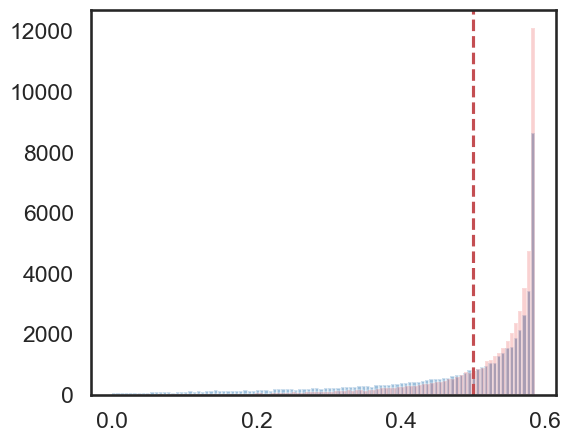

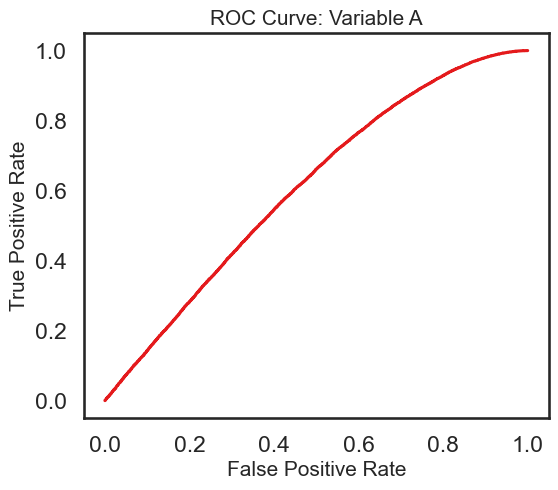

In [168]:
print("accuracy", accuracy)
threshhold = thresholds[np.argmax(tpr - fpr)]
# quantile = np.quantile(x_1, [accuracy])[0]
# print(quantile, threshhold)

T = 0.5
TP = np.sum(posterior[n1:, 1] > T)
TN = np.sum(posterior[:n0, 1] <= T)
FP = np.sum(posterior[:n0, 1] > T)
FN = np.sum(posterior[n1:, 1] <= T)

ACCU = (TP + TN) / (TP + TN + FP + FN)
# print(ACCU, accuracy)
# print(TP, TN, FP, FN)
# print(tp, tn, fp, fn)
print("TP + FP", TP + FP)
print("TPR", TP / (TP + FN))

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print(TPR, FPR)

# calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(
    y, posterior[:, 1], pos_label=1, drop_intermediate=False
)
auc = metrics.auc(fpr, tpr)
threshhold = thresholds[TP + FP]
# print(threshhold)
# print(tpr[TP + FP], fpr[np.argmax(TP + FP)])
print(auc)

# np.argmin(tpr < TPR)

# plot posterior distribution
plt.figure(figsize=(6, 5))
plt.hist(posterior[:n0, 1], bins=100, alpha=0.5, color=PALETTE[1])
plt.hist(posterior[n1:, 1], bins=100, alpha=0.2, color=PALETTE[0])
plt.axvline(x=threshhold, color="r", linestyle="--", label="Threshold")

# plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color=PALETTE[0])
plt.xlabel("False Positive Rate", size=15.0)
plt.ylabel("True Positive Rate", size=15.0)
plt.title("ROC Curve: Variable A", size=15.0)


# TP = np.sum((posterior[:,1] > threshhold) & (y == 1))
# TN = np.sum((posterior[:,1] <= threshhold) & (y == 0))
# FP = np.sum((posterior[:,1] > threshhold) & (y == 0))
# FN = np.sum((posterior[:,1] <= threshhold) & (y == 1))

# ACCU = (TP + TN) / (TP + TN + FP + FN)
# print(ACCU, accuracy)

(100000, 2) (100000, 1)


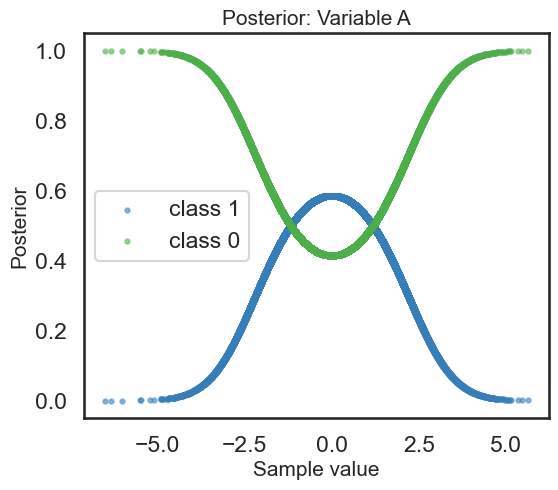

In [156]:
# plot the posterior
plt.figure(figsize=(6, 5))
print(posterior.shape, x.shape)
plt.scatter(x, posterior[:, 1], alpha=0.5, label="class 1", cmap=y, s=10)
plt.scatter(x, posterior[:, 0], alpha=0.5, label="class 0", cmap=y, s=10)

# plt.plot(np.sort(posterior[:,1]), color=PALETTE[0], label='Posterior class 1')
# plt.plot(np.sort(posterior[:,0]), color=PALETTE[1], label='Posterior class 0')
# plt.axhline(y=T, color='g', linestyle='--', label='Threshold')
plt.xlabel("Sample value", size=15.0)
plt.ylabel("Posterior", size=15.0)
plt.title("Posterior: Variable A", size=15.0)
plt.legend()

Text(0.5, 1.0, 'ROC Curve')

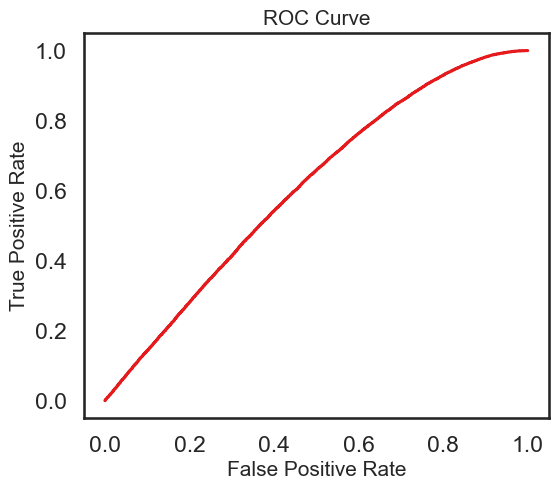

In [157]:
# convert the fpr, tpr, thresholds in a dataframe
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
# plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[0])
plt.xlabel("False Positive Rate", size=15.0)
plt.ylabel("True Positive Rate", size=15.0)
plt.title("ROC Curve", size=15.0)

In [158]:
# # find the threshold for accuracy at auc
# x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
# x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)
# x = np.vstack((x_0,x_1))
# threshhold = thresholds[np.argmax(tpr - fpr)]
# # plot the posterior
# plt.figure(figsize=(6, 5))
# print(x.shape, posterior.shape)
# plt.hist(x_0, bins=100, density=density, alpha=0.5, color=PALETTE[1])
# plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[0])
# # plt.axvline(x=threshhold, color='r', linestyle='--', label='Threshold')

# # print accuracy at auc
# accuracy
# # find the quantiles of the posterior
# quantile = np.quantile(x_1, [accuracy])
# # plot the quantile
# plt.axvline(x=quantile, color='g', linestyle='--', label='Quantile')

In [174]:
# define a function to generate the statistics
def generate_statistics_A(
    N,
    p,
    mu_class0,
    mu_class1,
    sig_class0,
    sig_class1,
    p_class0,
    p_class1,
    plot=False,
    density=True,
    scaler=8,
    label="Variable A",
):
    n0 = int(N * p_class0)
    n1 = N - n0
    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    pdf_class1 = multivariate_normal(mu_class1, sig_class1)

    x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
    x_2 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

    x = np.vstack((x_1, x_2))
    y = np.array([0] * n0 + [1] * n1).reshape(-1, 1)

    p_x_given_class0 = pdf_class0.pdf(x)
    p_x_given_class1 = pdf_class1.pdf(x)

    p_x = p_x_given_class0 * p_class0 + p_x_given_class1 * p_class1
    pos_class0 = p_x_given_class0 * p_class0 / p_x
    pos_class1 = p_x_given_class1 * p_class1 / p_x

    posterior = np.hstack((pos_class0.reshape(-1, 1), pos_class1.reshape(-1, 1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0, p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # correlation = np.corrcoef(x_1.T, x_2.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:, 1])
    pauc_90 = roc_auc_score(y, posterior[:, 1], max_fpr=0.1)
    pauc_98 = roc_auc_score(y, posterior[:, 1], max_fpr=0.02)
    fpr, tpr, thresholds = metrics.roc_curve(
        y, posterior[:, 1], pos_label=1, drop_intermediate=False
    )
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = metrics.f1_score(y, y_pred)
    report = metrics.classification_report(y, y_pred)
    # return MI, auc, pauc, tpr_s, sensitivity, specificity, accuracy, f1, report,  tn, fp, fn, tp
    # create a dictionary to store the statistics in order of correlation, accuracy, AUC, pAUC, F1,  MI, S@98, Sensitivity, Specificity, F1, TN, FP, FN, TP, report
    statistics_A = {
        # 'Correlation': truncate(correlation[0,1], 4),
        "Accuracy": accuracy,
        "F1": f1,
        "MI": MI,
        "AUC": auc,
        "pAUC_90": pauc_90,
        "pAUC_98": pauc_98,
        "S@98": tpr_s,
        # 'thresholds': thresholds,
        # 'Sensitivity': truncate(sensitivity),
        # 'Specificity': truncate(specificity),
        # 'TN': tn,
        # 'FP': fp,
        # 'FN': fn,
        # 'TP': tp
    }
    if plot:
        # plot the true pdfs using seaborn
        fig, ax = plt.subplots(figsize=(6, 5))
        # find the range of the x values
        x_min, x_max = np.min(x), np.max(x)
        xs = np.linspace(x_min-1, x_max+1, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame(
            {"x": xs, "pdf_class0": pdf_class0.pdf(xs), "pdf_class1": pdf_class1.pdf(xs)}
        )
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
        # find the quantiles of the posterior
        quantile = np.quantile(x_1, [accuracy])
        # plot the quantile
        # plt.axvline(x=quantile, color='g', linestyle='--', label='Threshold')
        # plot the true pdfs
        if density:
            sns.lineplot(df, x="x", y="pdf_class0", label="Control", color=PALETTE[1])
            sns.lineplot(df, x="x", y="pdf_class1", label="Cancer", color=PALETTE[0])
        else:
            plt.plot(
                df["x"], df["pdf_class0"] * n0 / scaler, color=PALETTE[1], linewidth=2
            )
            plt.plot(
                df["x"], df["pdf_class1"] * n1 / scaler, color=PALETTE[0], linewidth=2
            )
            plt.legend(["Control", "Cancer"])

        # set the labels and title
        plt.xlabel("")
        plt.ylabel("Density", size=0.5)
        # set the ticks size
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.title(f"{label}: N({mu_class0[0]},{p0}) vs N({mu_class1[0]},{p1})")

        # plot the ROC curve
        # convert the fpr, tpr, thresholds in a dataframe
        df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
        # plot the ROC curve
        plt.figure(figsize=(6, 5))
        plt.plot(df_roc["fpr"], df_roc["tpr"], color=PALETTE[0])
        plt.xlabel("False Positive Rate", size=15.0)
        plt.ylabel("True Positive Rate", size=15.0)
        plt.title(f"ROC Curve: {label}", size=15.0)
        return statistics_A, report, fig, posterior

    return statistics_A, report, posterior

\begin{tabular}{lllll}
\toprule
 & Variable A & Variable B & Variable C & Max \\
\midrule
Accuracy & 0.69 & 0.58 & 0.63 & A \\
F1 & 0.69 & 0.49 & 0.58 & A \\
MI & 0.11 & 0.03 & 0.4 & C \\
AUC & 0.76 & 0.61 & 0.7 & A \\
pAUC_90 & 0.6 & 0.55 & 0.63 & C \\
pAUC_98 & 0.54 & 0.53 & 0.63 & C \\
S@98 & 0.15 & 0.1 & 0.27 & C \\
\bottomrule
\end{tabular}



,Variable A,Variable B,Variable C,Max
Accuracy,0.69,0.58,0.63,A
F1,0.69,0.49,0.58,A
MI,0.11,0.03,0.4,C
AUC,0.76,0.61,0.7,A
pAUC_90,0.6,0.55,0.63,C
pAUC_98,0.54,0.53,0.63,C
S@98,0.15,0.1,0.27,C


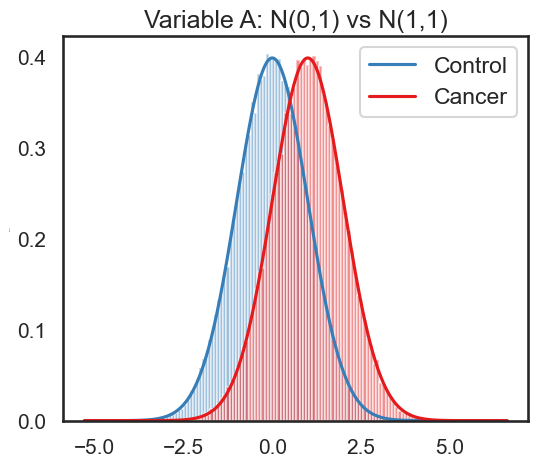

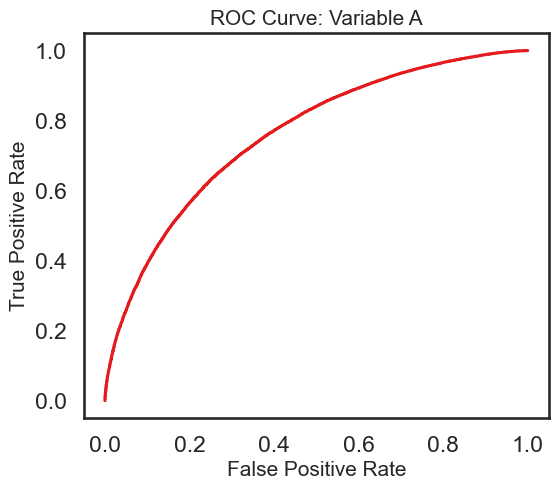

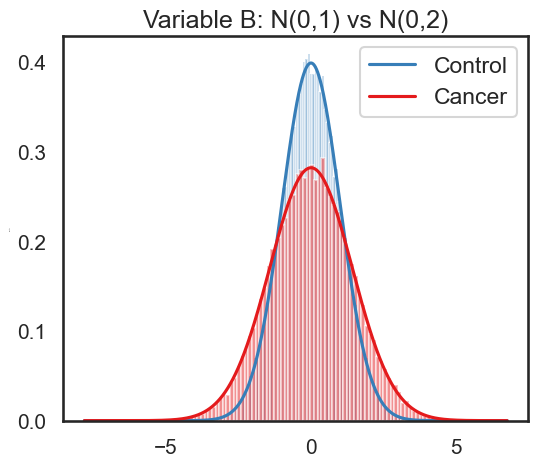

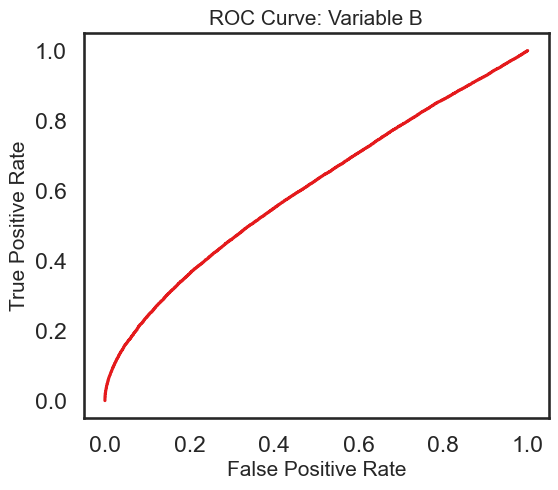

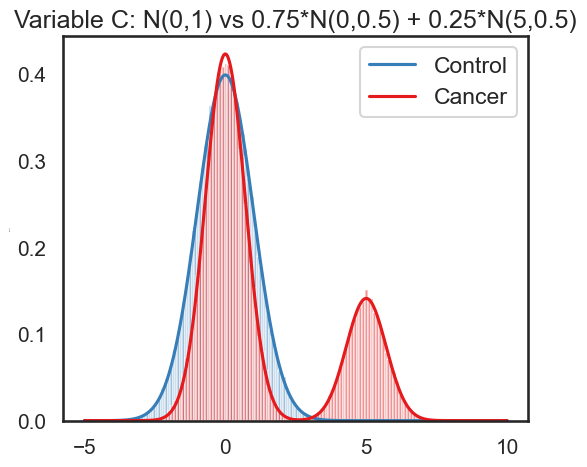

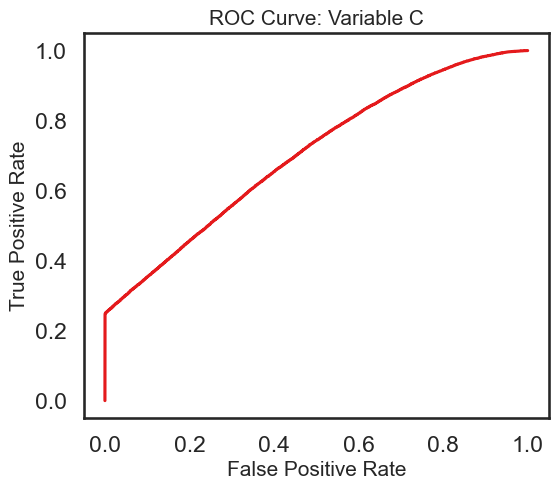

In [179]:
density = True
N = 100000
# Variable A Normal : N(-1,1) vs Cancer  N(1,1)
p = 1
p0, p1 = 1, 1
mu_0, mu_1 = 0, 1
mu_class0 = np.array([mu_0] * p)
mu_class1 = np.array([mu_1] * p)
sig_class0 = np.identity(p) * p0
sig_class1 = np.identity(p) * p1
p_class0, p_class1 = 0.5, 0.5
statistics_A, report_A, fig_A, posterior_A = generate_statistics_A(
    N,
    p,
    mu_class0,
    mu_class1,
    sig_class0,
    sig_class1,
    p_class0,
    p_class1,
    plot=True,
    density=density,
    scaler=11.5,
)
statistics_A_list = np.array(list(statistics_A.values()))

# Variable B Normal : N(0,1) vs Cancer  N(0, 2)
p0, p1 = 1, 2
mu_0, mu_1 = 0, 0
mu_class0 = np.array([mu_0] * p)
mu_class1 = np.array([mu_1] * p)
sig_class0 = np.identity(p) * p0
sig_class1 = np.identity(p) * p1
p_class0, p_class1 = 0.5, 0.5
statistics_B, report_B, fig_B, posterior_B = generate_statistics_A(
    N,
    p,
    mu_class0,
    mu_class1,
    sig_class0,
    sig_class1,
    p_class0,
    p_class1,
    plot=True,
    density=density,
    scaler=11.5,
    label="Variable B",
)
statistics_B_list = np.array(list(statistics_B.values()))

# Variable C Normal : N(0,2) vs Cancer  0.9*N(0,1) + 0.1*N(5,1)
split = (0.75, 0.25)
p0, p1 = 1, 0.5
p_class0, p_class1_0, p_class1_1 = p_class0, p_class1 * split[0], p_class1 * split[1]
n0 = int(N * p_class0)
n1 = N - n0
n1_0 = int(n1 * 0.75)
n1_1 = n1 - n1_0
p = 1
mu_class0 = np.array([0] * p)
mu_class1_0 = np.array([0] * p)
mu_class1_1 = np.array([5] * p)
sig_class0 = np.identity(p) * p0
sig_class1_0 = np.identity(p) * p1
sig_class1_1 = np.identity(p) * p1

statistics_C, report_C, fig_C, posterior_C = calculate_statistics_B(
    n0,
    n1_0,
    n1_1,
    p,
    mu_class0,
    mu_class1_0,
    mu_class1_1,
    sig_class0,
    sig_class1_0,
    sig_class1_1,
    p_class0,
    p_class1_0,
    p_class1_1,
    plot=True,
    density=density,
    scaler=8,
    label="Variable C",
    split=split,
)
statistics_C_list = np.array(list(statistics_C.values()))

# generate function to return '>' if the value A is greater than B, '<' if the value A is less than B, and '=' if the values are equal
max_list = np.array(
    [
        np.argmax([statistics_A_list[i], statistics_B_list[i], statistics_C_list[i]])
        for i in range(len(statistics_A_list))
    ]
)
var_list = ["A", "B", "C"]
max_var_list = np.array([var_list[i] for i in max_list])
# print the statistics as a dataframe
# round the statistics to 2 decimal places
statistics_A_list = np.round(statistics_A_list, 2)
statistics_B_list = np.round(statistics_B_list, 2)
statistics_C_list = np.round(statistics_C_list, 2)
df = pd.DataFrame(
    np.vstack(
        (statistics_A_list, statistics_B_list, statistics_C_list, max_var_list)
    ).T,
    index=statistics_A.keys(),
    columns=["Variable A", "Variable B", "Variable C", "Max"],
)
print(df.to_latex())
df

In [122]:
[
    max(statistics_A_list[i], statistics_B_list[i], statistics_C_list[i])
    for i in range(len(statistics_A_list))
]

[0.84182,
 0.841699691765742,
 0.336856848247884,
 0.9215746548000001,
 0.7881654863157894,
 0.47994]

Accuracy = TP + TN /N = 

In [ ]:
# Accuracy = (TP+TN)/(TP+TN+FP+FN)
# Sensitivity = TP/(TP+FN)
# Specificity = TN/(TN+FP)
# Precision = TP/(TP+FP)

45000 5000 4500 500
\begin{tabular}{llll}
\toprule
 & Variable A & Relations & Variable B \\
\midrule
Accuracy & 0.91162 & > & 0.90666 \\
F1 & 0.2749794913863823 & > & 0.1438268207668318 \\
MI & 0.046245273124224884 & < & 0.055724269043636754 \\
AUC & 0.7049586711111111 & > & 0.6351072044444445 \\
pAUC & 0.6356362339181287 & > & 0.5531045847953217 \\
S@98 & 0.2444 & > & 0.1124 \\
\bottomrule
\end{tabular}



,Variable A,Relations,Variable B
Accuracy,0.91162,>,0.90666
F1,0.2749794913863823,>,0.1438268207668318
MI,0.046245273124224884,<,0.055724269043636754
AUC,0.7049586711111111,>,0.6351072044444445
pAUC,0.6356362339181287,>,0.5531045847953217
S@98,0.2444,>,0.1124


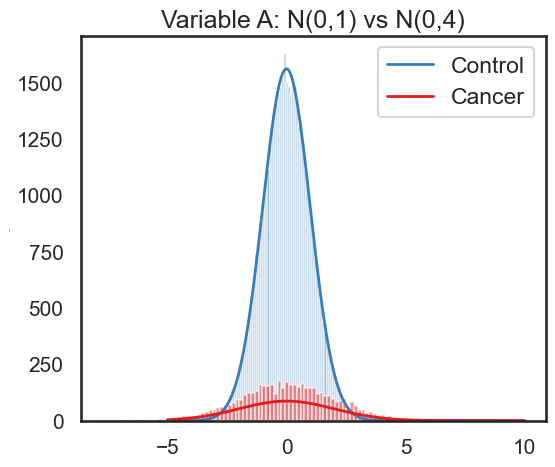

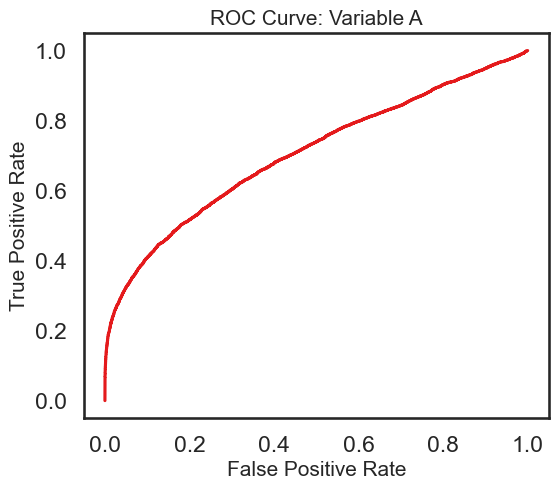

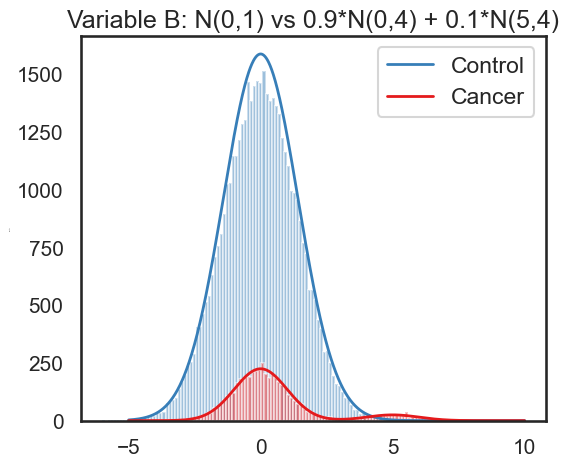

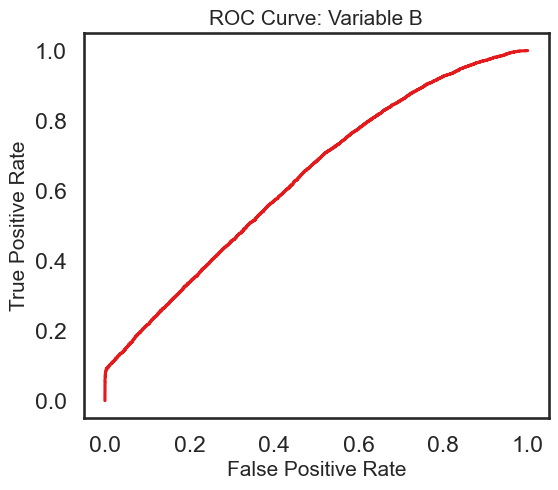

In [47]:
N = 50000
p = 1
p0, p1 = 1, 4
mu_class0 = np.array([0] * p)
mu_class1 = np.array([0] * p)
sig_class0 = np.identity(p) * p0
sig_class1 = np.identity(p) * p1
p_class0, p_class1 = 0.9, 0.1
statistics_A, report, fig, posterior = generate_statistics_A(
    N,
    p,
    mu_class0,
    mu_class1,
    sig_class0,
    sig_class1,
    p_class0,
    p_class1,
    plot=True,
    density=False,
    scaler=11.5,
)
statistics_A_list = np.array(list(statistics_A.values()))

N = 50000
p_class0, p_class1_0, p_class1_1 = 0.9, 0.1 * 0.9, 0.1 * 0.1
n0 = int(N * p_class0)
n1 = N - n0
n1_0 = int(n1 * 0.9)
n1_1 = n1 - n1_0
print(n0, n1, n1_0, n1_1)
p = 1
mu_class0 = np.array([0] * p)
mu_class1_0 = np.array([0] * p)
mu_class1_1 = np.array([5] * p)
sig_class0 = np.identity(p) * 2
sig_class1_0 = np.identity(p) * 1
sig_class1_1 = np.identity(p) * 1

statistics_B, report, fig_B, posterior = calculate_statistics_B(
    n0,
    n1_0,
    n1_1,
    p,
    mu_class0,
    mu_class1_0,
    mu_class1_1,
    sig_class0,
    sig_class1_0,
    sig_class1_1,
    p_class0,
    p_class1_0,
    p_class1_1,
    plot=True,
    density=False,
    scaler=8,
)
statistics_B_list = np.array(list(statistics_B.values()))

# generate function to return '>' if the value A is greater than B, '<' if the value A is less than B, and '=' if the values are equal
relations = np.array(
    [
        compare(statistics_A_list[i], statistics_B_list[i])
        for i in range(len(statistics_A_list))
    ]
)
# print the statistics as a dataframe
df = pd.DataFrame(
    np.vstack((statistics_A_list, relations, statistics_B_list)).T,
    index=statistics_A.keys(),
    columns=["Variable A", "Relations", "Variable B"],
)
print(df.to_latex())
df